In [151]:
%matplotlib inline

# Imports
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [152]:
# Helper functions
def grab_fields(file, form):
    toret = {}
    fields = grab_fields_coords(file)['fields']
    for field in fields:
        name = field['field']
        x = field['coord_pixel'][0]
        y = field['coord_pixel'][1]
        w = field['width']
        h = field['height']
    
        form_field = form[y:y+h, x:x+w]
        toret[name] = form_field
    
    return toret

def grab_fields_coords(file):
    with open(file, "r") as f:
        content = json.loads(f.read())

    return content 

def show_image(image, name=None, true_size=False):
    image = image.astype('uint8')
    if true_size:
        show_image_true_size(image, name=name)
    else:
        plt.title(name)
        plt.xlabel(str(image.shape[1]) + " px")
        plt.ylabel(str(image.shape[0]) + " px")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

def show_image_true_size(image, name=None):
    dpi = 80
    height, width = image.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.show()

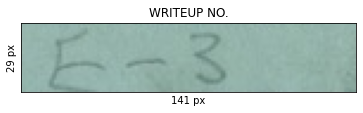

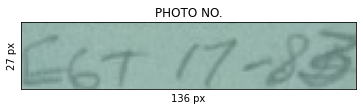

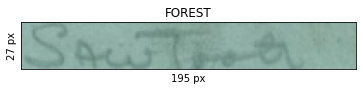

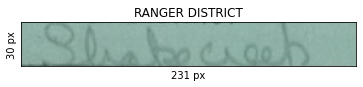

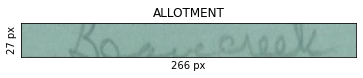

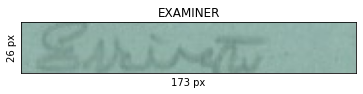

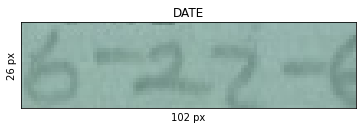

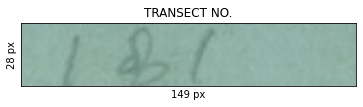

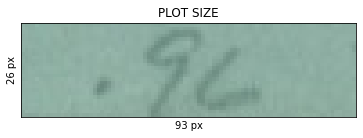

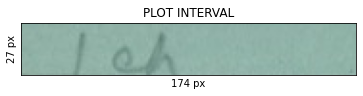

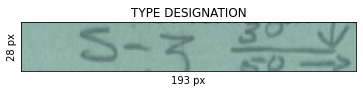

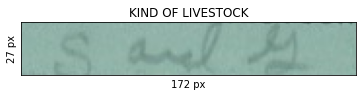

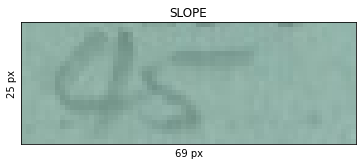

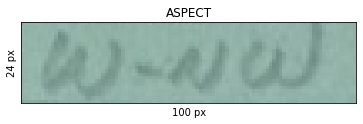

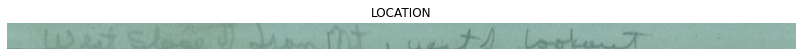

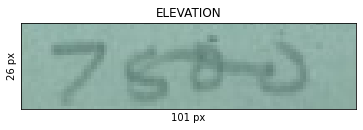

In [153]:
form = cv2.imread("highRes_ForestService.jpg")
# Taking the JSON field with no form lines
fields = grab_fields("all_fields_conservative.json", form)
for key, val in fields.items():
    if key == "LOCATION":
        show_image(val, name=key, true_size=True)
    else:
        show_image(val, name=key)

##### Objective. Segmentate characters separated by a  black gap between the two.

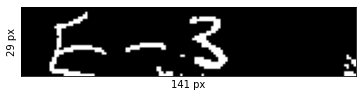

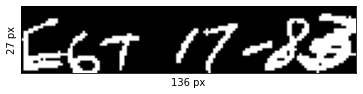

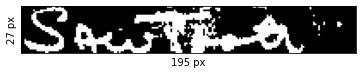

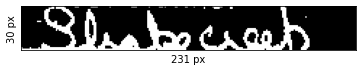

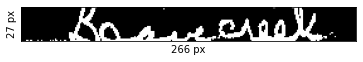

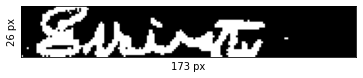

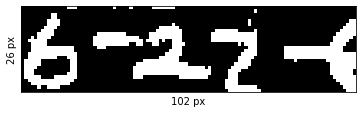

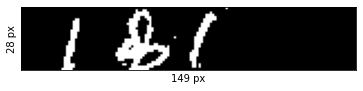

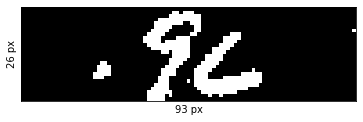

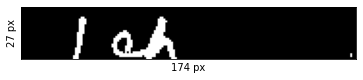

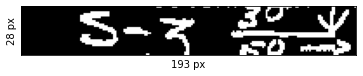

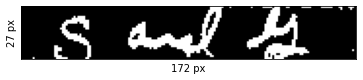

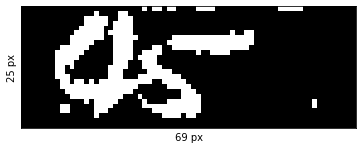

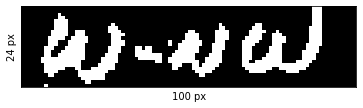

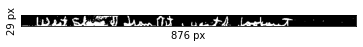

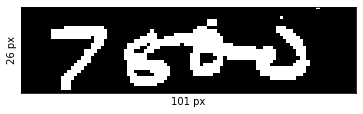

In [154]:
"""
 We're going to work with the thresholded images
"""
t_imgs = {}
for key, val in fields.items():
    g_img = cv2.cvtColor(val, cv2.COLOR_BGR2GRAY)
    _, t_img = cv2.threshold(g_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    t_imgs[key] = t_img
    show_image(t_img)

In [155]:
def create_h_v_image_proj(thresh_img):
    """Create vertical and horizontal histogram and images.
    """
    h, w = thresh_img.shape[:2]
    h_hist_img = np.zeros(thresh_img.shape[:2], dtype='uint8')
    v_hist_img = np.zeros(thresh_img.shape[:2], dtype='uint8')
    
    # Normalizes the image so the possibles values are 0 and 1, then we can simply sum all the ones
    word_v_hist_proj = np.sum(thresh_img / 255, axis=0)
    word_h_hist_proj = np.sum(thresh_img / 255, axis=1)
    
    m = np.max(word_h_hist_proj)
    for row in range(thresh_img.shape[0]):
        h_hist_img = cv2.line(
            h_hist_img, 
            (0,row), 
            (int(word_h_hist_proj[row] * w/m),row), 
            (255,255,255), 
            1)
    m = np.max(word_v_hist_proj)
    for col in range(thresh_img.shape[1]):
        v_hist_img = cv2.line(
            v_hist_img, 
            (col,h), 
            (col,h - int(word_v_hist_proj[col]*h/m)), 
            (255,255,255),
            1)
    return word_v_hist_proj, word_h_hist_proj, v_hist_img, h_hist_img

Average px freq: 2
Max px freq: 15.0
Low px freq: 2.0


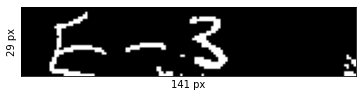

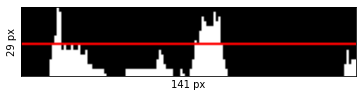

Average px freq: 6
Max px freq: 18.0
Low px freq: 2.0


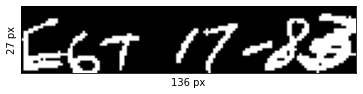

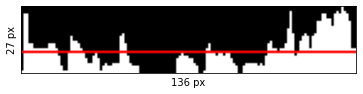

Average px freq: 8
Max px freq: 25.0
Low px freq: 2.0


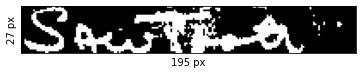

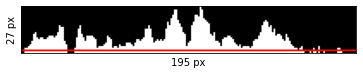

Average px freq: 7
Max px freq: 28.0
Low px freq: 2.0


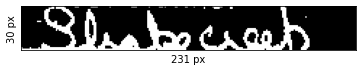

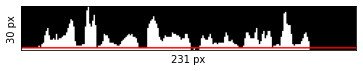

Average px freq: 6
Max px freq: 23.0
Low px freq: 2.0


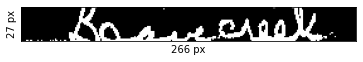

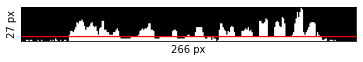

Average px freq: 7
Max px freq: 20.0
Low px freq: 2.0


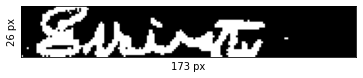

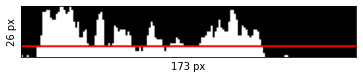

Average px freq: 7
Max px freq: 18.0
Low px freq: 3.0


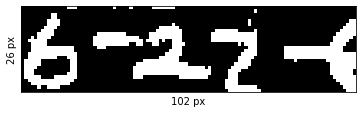

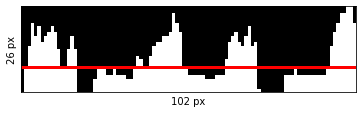

Average px freq: 3
Max px freq: 26.0
Low px freq: 2.0


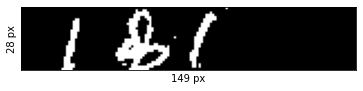

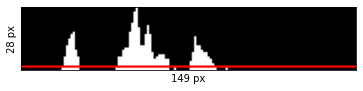

Average px freq: 4
Max px freq: 17.0
Low px freq: 2.0


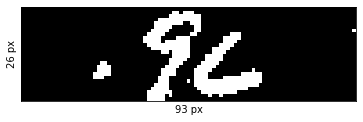

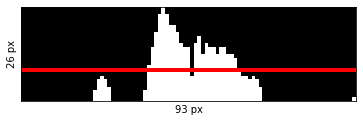

Average px freq: 2
Max px freq: 18.0
Low px freq: 2.0


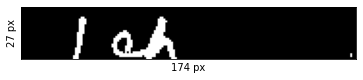

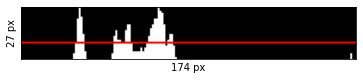

Average px freq: 6
Max px freq: 22.0
Low px freq: 2.0


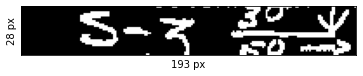

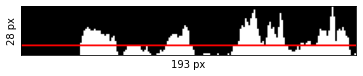

Average px freq: 5
Max px freq: 24.0
Low px freq: 2.0


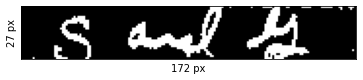

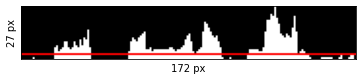

Average px freq: 5
Max px freq: 18.0
Low px freq: 2.0


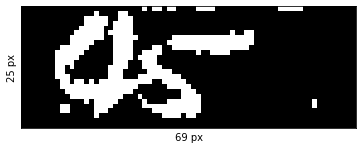

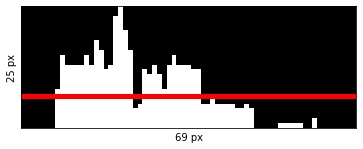

Average px freq: 6
Max px freq: 16.0
Low px freq: 2.0


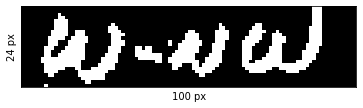

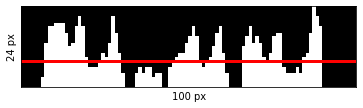

Average px freq: 6
Max px freq: 28.0
Low px freq: 2.0


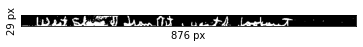

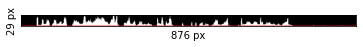

Average px freq: 6
Max px freq: 15.0
Low px freq: 2.0


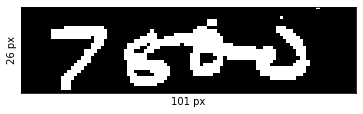

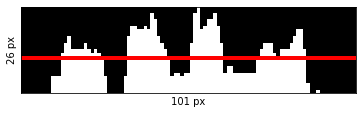

In [156]:
"""
 Plots some images to see if I could find some correlation between the minimum, maximum, and 
 average pixel frequency.
"""
for key, f_img in t_imgs.items():
    v_hist, h_hist, v_h_img, h_h_img = create_h_v_image_proj(f_img)
    print("Average px freq:", round(np.average(v_hist)))
    print("Max px freq:", max(v_hist))
    bigger_than_zero = v_hist > 1
    print("Low px freq:", np.amin(v_hist, initial=max(v_hist), where=bigger_than_zero)) # Bigger than 1px
    show_image(f_img)
    hist_img = v_h_img.copy()
    hist_img = cv2.cvtColor(hist_img, cv2.COLOR_GRAY2BGR)
    hist_img = cv2.line(hist_img, (0, int(max(v_hist))), (f_img.shape[1], int(max(v_hist))), (0, 0, 255), 1)
    show_image(hist_img)

Field: WRITEUP NO.
[(35, 44), (63, 67), (68, 71), (86, 136)] #TOTAL: 4


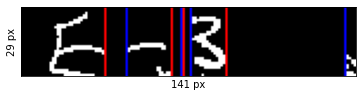

Field: PHOTO NO.
[(47, 63), (71, 74), (87, 90)] #TOTAL: 3


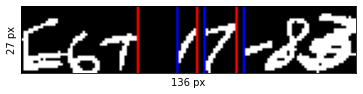

Field: FOREST
[(26, 31), (164, 168), (171, 173), (176, 184)] #TOTAL: 4


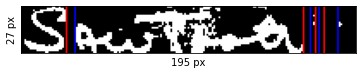

Field: RANGER DISTRICT
[(116, 119)] #TOTAL: 1


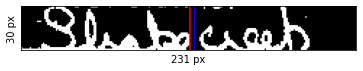

Field: ALLOTMENT
[(5, 7), (8, 13), (16, 23), (25, 27), (28, 31), (35, 38), (154, 156), (242, 245), (247, 249)] #TOTAL: 9


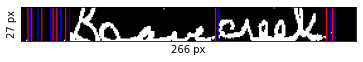

Field: EXAMINER
[(0, 3), (125, 136)] #TOTAL: 2


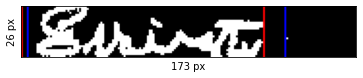

Field: DATE
[(16, 22), (72, 80)] #TOTAL: 2


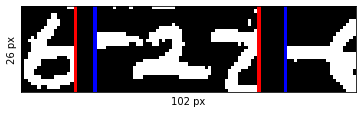

Field: TRANSECT NO.
[(25, 42), (65, 68), (86, 91)] #TOTAL: 3


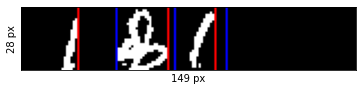

Field: PLOT SIZE
[(24, 34), (66, 92)] #TOTAL: 2


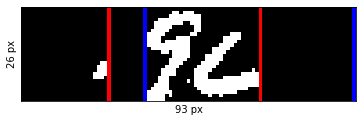

Field: PLOT INTERVAL
[(33, 47), (80, 171)] #TOTAL: 2


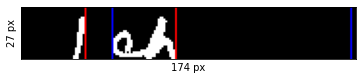

Field: TYPE DESIGNATION
[(55, 59), (74, 78), (99, 105), (108, 113), (119, 121), (189, 192)] #TOTAL: 6


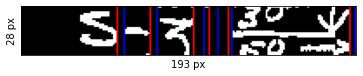

Field: KIND OF LIVESTOCK
[(6, 17), (35, 55), (103, 107), (148, 154), (159, 163), (164, 168)] #TOTAL: 6


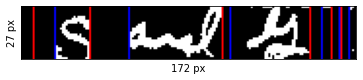

Field: SLOPE
[(47, 53), (57, 60)] #TOTAL: 2


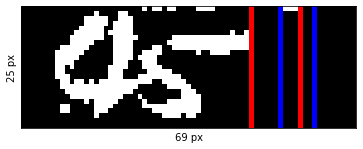

Field: ASPECT
[(30, 34), (41, 44), (61, 66)] #TOTAL: 3


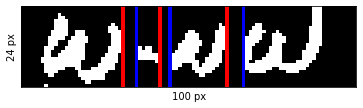

Field: LOCATION
[(3, 5), (18, 21), (22, 29), (30, 36), (121, 128), (129, 134), (256, 259), (344, 346), (348, 350), (351, 355), (375, 378), (397, 420), (424, 445), (460, 466), (542, 544), (548, 567), (570, 573), (710, 716), (742, 765), (791, 839)] #TOTAL: 20


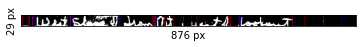

Field: ELEVATION
[(25, 31), (86, 89)] #TOTAL: 2


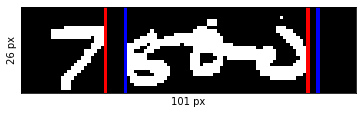

In [157]:
def get_black_gap_seg_points(v_hist):
    """Find black gaps and return them.
    
    Parameters
    ----------
    v_hist - list
        Contains the vertical histogram pixel frequency of one image
        
    Algorithm
    ---------
    The main idea is to find when a word ends and when the next one start. This will comprise one element saved on
    the tuple (end_word, beg_word).
    It explores the vertical histogram values from left to right accounting when we're passing over a possible
    character. When it notices that we're over a character, it continues exploring to the right until a black line
    is found (end_w). Then, it continues exploring to right until a white line is found (beg_w) and saves it.
    """
# ~~~ Another function ~~~~
#     max_v = max(v_hist)
#     bigger_than_zero = v_hist > 1
#     min_v = np.amin(v_hist, initial=max(v_hist), where=bigger_than_zero)
#     avg_v = np.average(v_hist)
# ~~~~~~~~~~~~~~~~~~~~~~~~

    beg_word = None # Placeholder for the begining of a word
    end_word = None # Placeholder for the end of a word
    word_seen = False # Controls wheter we're over an image or not
    gaps = [] # Stores all gaps, that is, tuples of (end_w, beg_w)
    index = 0 # Controls the exact position where the tuple is inserted in gaps, so it follows left-to-right order
    for i in range(len(v_hist)):
        # Current pixel frequency value
        curr = v_hist[i]
        # If we're not over a word
        if not word_seen:
            if end_word != None: # If we have found an end of the word 
                if curr <= 0: # If it's a black advance one iteration of the loop
                    continue
                else: # If it's a white line we record the gap. We've reached the next word.
                    beg_word = i 
                    gaps.insert(index, (end_word, beg_word))
                    index += 1
                    end_word = None
                    #img = cv2.line(img, (beg_word, 0), (beg_word, img.shape[0]), (255, 0, 0), 1)
            else: # If we didn't find an end of the word
                if curr <= 0: # Advance over black lines
                    continue
                else: # Once we've hit for the first time a white line we're about to explore a word.
                    word_seen = True
                    continue
        else: # We're now over a word
            if curr > 0: # Iterate loop skipping through all the content of the word.
                continue
            else: # We've reached the end of the word
                end_word = i - 1
                word_seen = False
                #img = cv2.line(img, (end_word, 0), (end_word, img.shape[0]), (0, 0, 255), 1)
    #show_image(img)
    return gaps
    
        
# f_img = t_imgs['PLOT SIZE']
# show_image(f_img)
# v_hist, _, v_hist_img, _ = create_h_v_image_proj(f_img)
# get_black_gap_seg_points(v_hist)
# show_image(v_hist_img)

"""Visualizaiton.
 The red line represent the end of a word and the blue ones the begining of a word.
"""
all_black_gaps = {}
hists = {}
for key, f_img in t_imgs.items():
    v_hist, _, _, _ = create_h_v_image_proj(f_img)
    hists[key] = v_hist
    black_gaps = get_black_gap_seg_points(v_hist)
    all_black_gaps[key] = black_gaps
    print(f"Field: {key}\n{black_gaps} #TOTAL: {len(black_gaps)}")
    img = f_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for gap in black_gaps:
        end_word, beg_word = gap
        img = cv2.line(img, (end_word, 0), (end_word, img.shape[0]), (0, 0, 255), 1)
        img = cv2.line(img, (beg_word, 0), (beg_word, img.shape[0]), (255, 0, 0), 1)
    show_image(img)

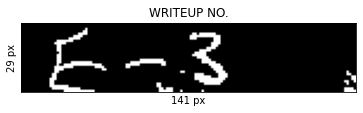

[(35, 44), (63, 67), (68, 71), (86, 136)] #TOTAL: 4


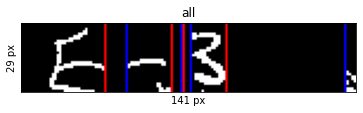

[(35, 44), (63, 71), (86, 136)] #TOTAL: 3


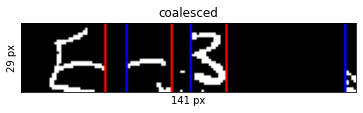

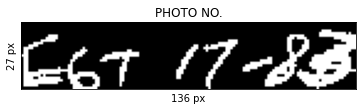

[(47, 63), (71, 74), (87, 90)] #TOTAL: 3


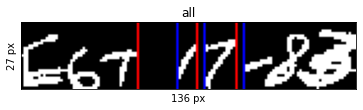

[(47, 63), (71, 74), (87, 90)] #TOTAL: 3


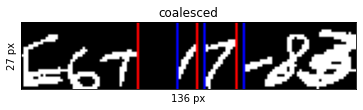

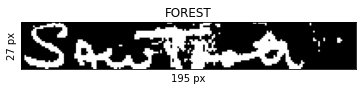

[(26, 31), (164, 168), (171, 173), (176, 184)] #TOTAL: 4


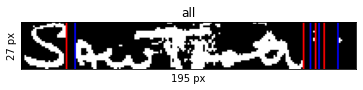

[(26, 31), (164, 184)] #TOTAL: 2


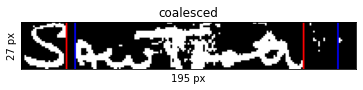

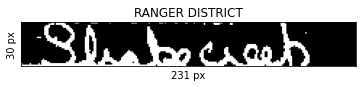

[(116, 119)] #TOTAL: 1


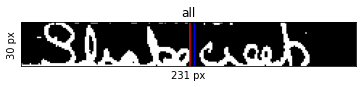

[(116, 119)] #TOTAL: 1


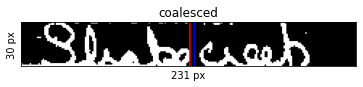

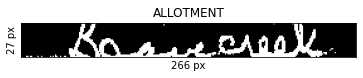

[(5, 7), (8, 13), (16, 23), (25, 27), (28, 31), (35, 38), (154, 156), (242, 245), (247, 249)] #TOTAL: 9


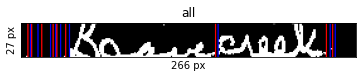

[(5, 38), (154, 156), (242, 249)] #TOTAL: 3


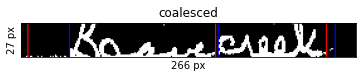

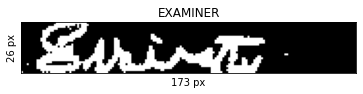

[(0, 3), (125, 136)] #TOTAL: 2


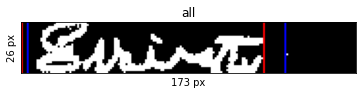

[(0, 3), (125, 136)] #TOTAL: 2


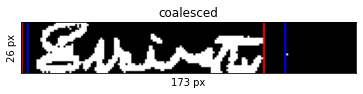

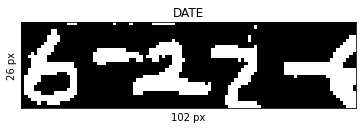

[(16, 22), (72, 80)] #TOTAL: 2


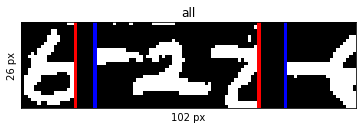

[(16, 22), (72, 80)] #TOTAL: 2


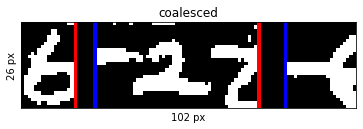

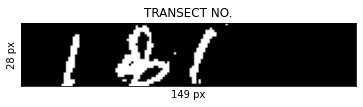

[(25, 42), (65, 68), (86, 91)] #TOTAL: 3


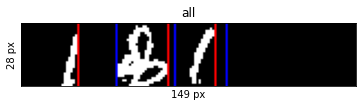

[(25, 42), (65, 68), (86, 91)] #TOTAL: 3


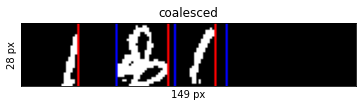

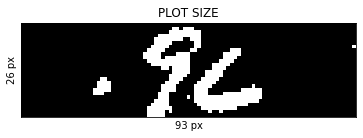

[(24, 34), (66, 92)] #TOTAL: 2


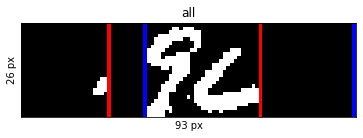

[(24, 34), (66, 92)] #TOTAL: 2


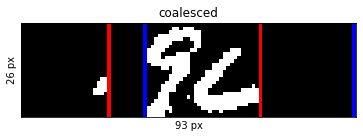

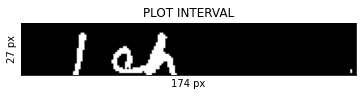

[(33, 47), (80, 171)] #TOTAL: 2


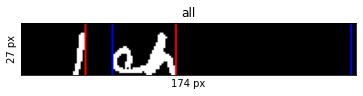

[(33, 47), (80, 171)] #TOTAL: 2


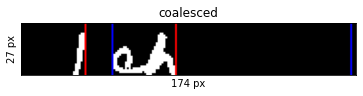

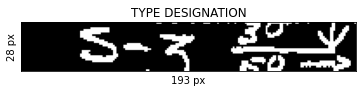

[(55, 59), (74, 78), (99, 105), (108, 113), (119, 121), (189, 192)] #TOTAL: 6


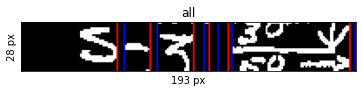

[(55, 59), (74, 78), (99, 113), (119, 121), (189, 192)] #TOTAL: 5


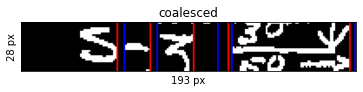

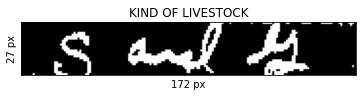

[(6, 17), (35, 55), (103, 107), (148, 154), (159, 163), (164, 168)] #TOTAL: 6


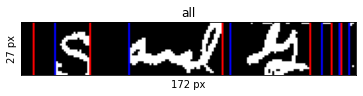

[(6, 17), (35, 55), (103, 107), (148, 168)] #TOTAL: 4


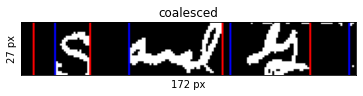

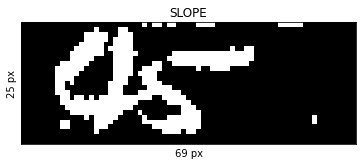

[(47, 53), (57, 60)] #TOTAL: 2


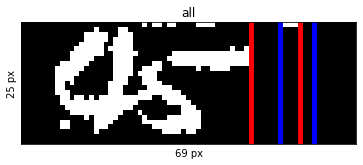

[(47, 60)] #TOTAL: 1


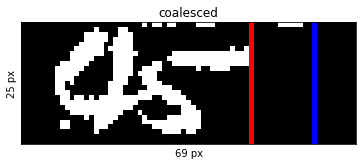

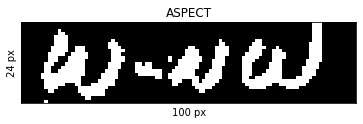

[(30, 34), (41, 44), (61, 66)] #TOTAL: 3


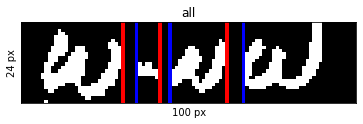

[(30, 34), (41, 44), (61, 66)] #TOTAL: 3


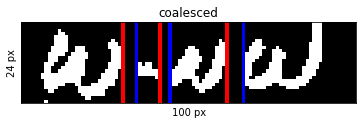

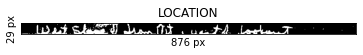

[(3, 5), (18, 21), (22, 29), (30, 36), (121, 128), (129, 134), (256, 259), (344, 346), (348, 350), (351, 355), (375, 378), (397, 420), (424, 445), (460, 466), (542, 544), (548, 567), (570, 573), (710, 716), (742, 765), (791, 839)] #TOTAL: 20


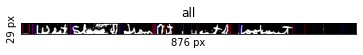

[(3, 5), (18, 36), (121, 134), (256, 259), (344, 355), (375, 378), (397, 445), (460, 466), (542, 573), (710, 716), (742, 765), (791, 839)] #TOTAL: 12


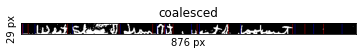

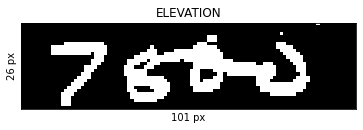

[(25, 31), (86, 89)] #TOTAL: 2


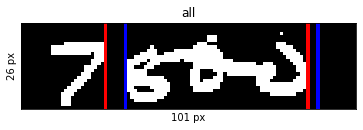

[(25, 31), (86, 89)] #TOTAL: 2


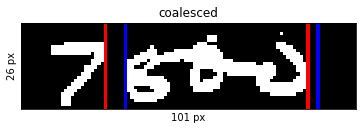

In [158]:
def coalesce_black_gaps(black_gaps):
    """Coalesces near elements.
    
    Parameters
    ----------
    black_gaps - list
        List of tuples. Each tuple (end_of_word, beg_of_word) represent a black gap.
    
    Algorithm
    ---------
    The main idea behind this algorithm is to compare a current tuple with its right neighbor. If it falls below 
    the threshold distance, then both are coalesced into one single element. It continues to do that until that 
    condition is not met. Then a new element is formed, it will be composed of the end_of_word of the current
    element and the beg_of_word of the last element that was compared to.
    If on the first comparison it doesn't meet the criteria it will be added as is.
    """
    gaps = []
    index = 0
    i = 0
    j = 0
    thresh = 5
    while i < len(black_gaps):
        new_g = None
        curr = black_gaps[i]
        tmp = curr
        j = i + 1
        if j < len(black_gaps):
            cmp = black_gaps[j]
            while (cmp[0] - tmp[1]) <= thresh and j < len(black_gaps):
                new_g = (curr[0], cmp[1])
                tmp = cmp
                j += 1
                if j >= len(black_gaps):
                    break
                cmp = black_gaps[j]
        if new_g == None:
            gaps.insert(index, curr)
            i += 1
        else:
            gaps.insert(index, new_g)
            i = j
        index += 1
    return gaps

coalesced_gaps = {}
for key, gaps in all_black_gaps.items():
    coal = coalesce_black_gaps(gaps)
    coalesced_gaps[key] = coal


# Showing results
for key, f_img in t_imgs.items():
    img_all = f_img.copy()
    img_coal = f_img.copy()
    img_all = cv2.cvtColor(img_all, cv2.COLOR_GRAY2BGR)
    img_coal = cv2.cvtColor(img_coal, cv2.COLOR_GRAY2BGR)
    
    all_black = all_black_gaps[key]
    all_coal = coalesced_gaps[key]
    
    for g in all_black:
        end_word, beg_word = g
        img_all = cv2.line(img_all, (end_word, 0), (end_word, f_img.shape[0]), (0, 0, 255), 1)
        img_all = cv2.line(img_all, (beg_word, 0), (beg_word, f_img.shape[0]), (255, 0, 0), 1)
    for g in all_coal:
        end_word, beg_word = g
        img_coal = cv2.line(img_coal, (end_word, 0), (end_word, f_img.shape[0]), (0, 0, 255), 1)
        img_coal = cv2.line(img_coal, (beg_word, 0), (beg_word, f_img.shape[0]), (255, 0, 0), 1)
    
    show_image(f_img, name=key)
    print(f"{all_black} #TOTAL: {len(all_black)}")
    show_image(img_all, "all")
    print(f"{all_coal} #TOTAL: {len(all_coal)}")
    show_image(img_coal, "coalesced")

RANGER DISTRICT [(0, 116), (119, 198)]
SLOPE [(7, 47), (60, 60)]


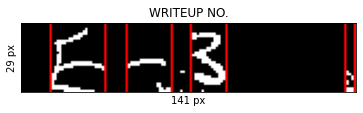

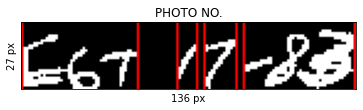

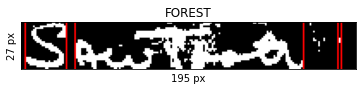

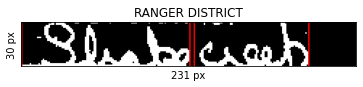

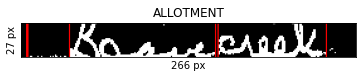

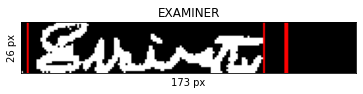

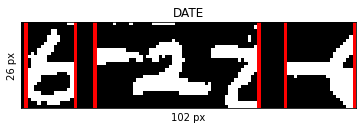

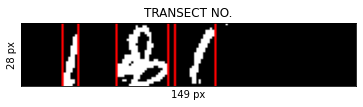

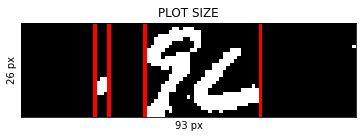

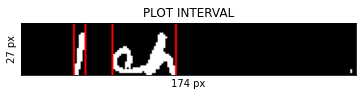

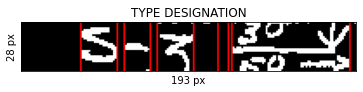

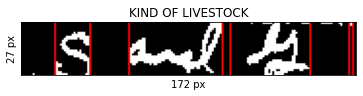

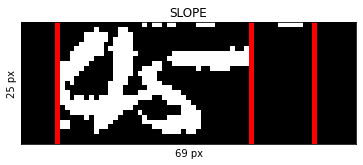

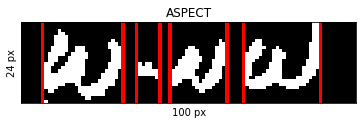

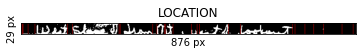

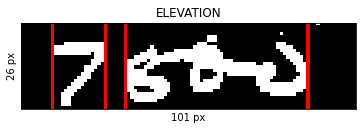

In [159]:
def extract_words(coalesced_gaps, hists):
    all_words = {}
    for key, gaps in coalesced_gaps.items():
        words = []
        v_hist = hists[key]
        prev_beg_w = None
        index = 0
        # We have to take care both left and right side of the gap
        if len(gaps) == 1:
            end_w, beg_w = gaps[0]
            # Take care of the left word
            while v_hist[index] <= 0 and index < len(v_hist) and index < end_w:
                index += 1
            words.append((index, end_w))
            # Take care of the right word
            index = len(v_hist) - 1
            while v_hist[index] <= 0 and index >= 0 and index > beg_w:
                index -= 1
            words.append((beg_w, index))
            print(key, words)
        else:
            for idx, g in enumerate(gaps):
                end_w, beg_w = g
                # For the first word jump over all black pixels
                if idx == 0:
                    # Grab the first word
                    while v_hist[index] <= 0 and index < len(v_hist):
                        index += 1
                    if index < end_w:
                        words.append((index, end_w))
                    # Save current beg_word so we could use it with the next item
                    prev_beg_w = beg_w
                # For the last word stop
                elif idx == len(gaps) - 1:
                    # Grab the last middle word
                    if prev_beg_w != None:
                        words.append((prev_beg_w, end_w))
                    # Grab the last word
                    index = len(v_hist) - 1
                    while v_hist[index] <= 0 and index >= 0:
                        index -= 1
                    if index > beg_w:
                        words.append((beg_w, index))
                else:
                    if prev_beg_w != None:
                        words.append((prev_beg_w, end_w))
                        prev_beg_w = beg_w
                    else:
                        print("How it got here?! :'(")

        all_words[key] = words
    
    return all_words


all_words = extract_words(coalesced_gaps, hists)

for key, f_img in t_imgs.items():
    img = f_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    words = all_words[key]
    
    for w in words:
        beg_word, end_word = w
        img = cv2.line(img, (beg_word, 0), (beg_word, img.shape[0]), (0, 0, 255), 1)
        img = cv2.line(img, (end_word, 0), (end_word, img.shape[0]), (0, 0, 255), 1)
    show_image(img, name=key)

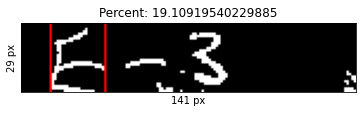

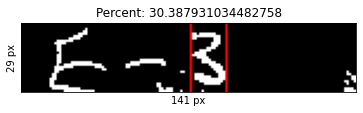

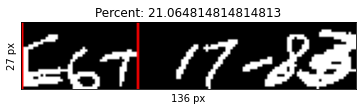

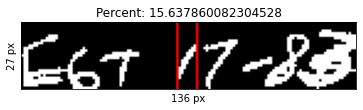

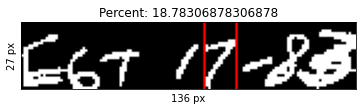

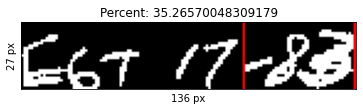

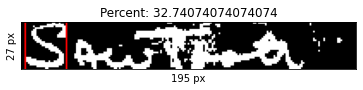

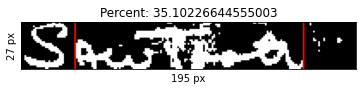

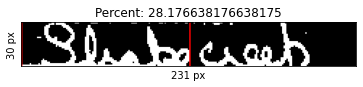

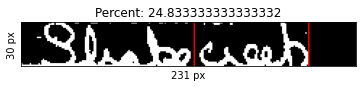

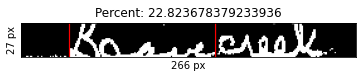

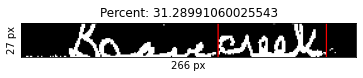

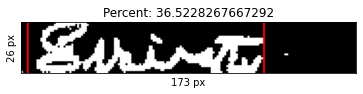

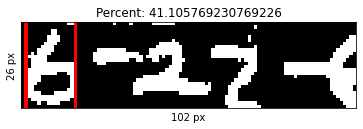

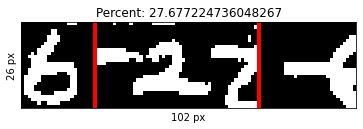

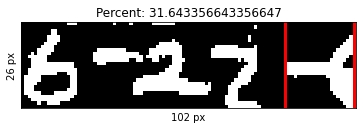

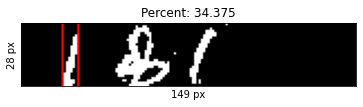

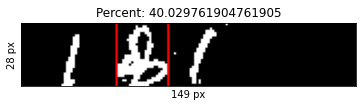

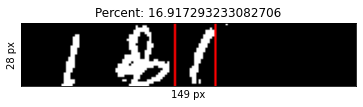

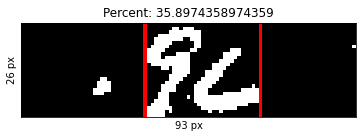

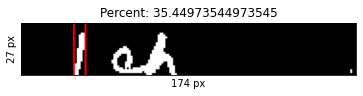

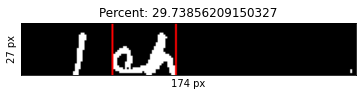

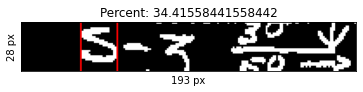

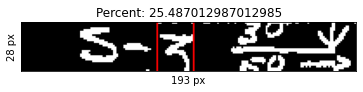

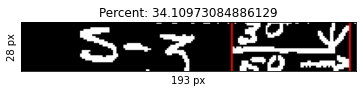

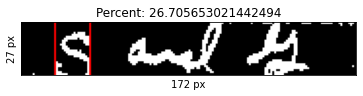

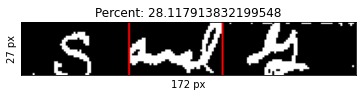

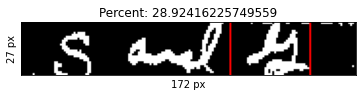

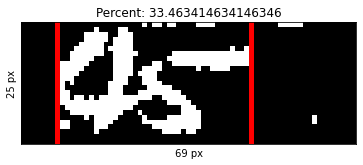

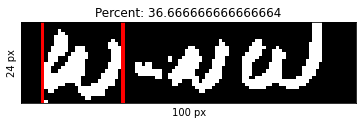

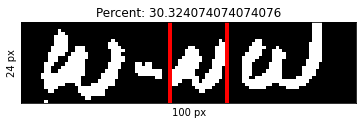

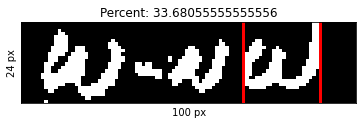

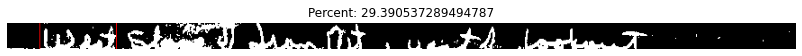

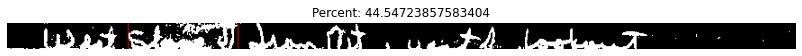

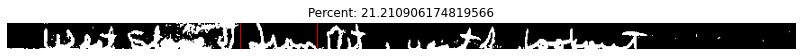

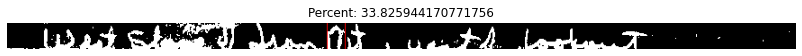

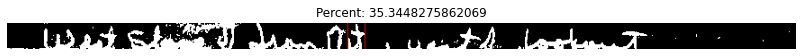

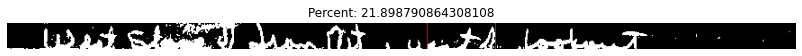

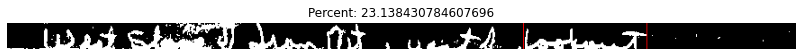

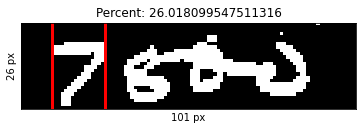

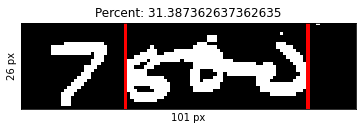

In [160]:
# Clean word extractions...
def clean_word_extractions(all_words, hists, t_imgs):
    to_ret = {}
    for key, words in all_words.items():
        hist = hists[key]
        img = cv2.cvtColor(t_imgs[key].copy(), cv2.COLOR_GRAY2BGR)
        height_img = t_imgs[key].shape[0]
        cleaned = []
        for word in words:
            img = cv2.cvtColor(t_imgs[key].copy(), cv2.COLOR_GRAY2BGR)
            x1, x2 = word
            sub_hist = hist[x1:x2 + 1] 
            # Calculate percentage of white pixels
            total_px = len(sub_hist) * height_img
            white_px = sum(sub_hist)
            percent_white_px = (white_px / total_px) * 100
            if percent_white_px > 14:
                cleaned.append(word)
                img = cv2.line(img, (x1, 0), (x1, height_img), (0, 0, 255), 1)
                img = cv2.line(img, (x2, 0), (x2, height_img), (0, 0, 255), 1)
                if key == "LOCATION":
                    show_image(img, name=f"Percent: {percent_white_px}", true_size=True)
                else:
                    show_image(img, name=f"Percent: {percent_white_px}")
        to_ret[key] = cleaned

all_clean = clean_word_extractions(all_words, hists, t_imgs)